In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Winter 2020/DL/Project 2/models/'
!cp /content/gdrive/My\ Drive/Winter\ 2020/DL/Project\ 2/data/*.zip .
!unzip /content/sudoku.zip
!mkdir /content/test
!unzip /content/sudoku_test.zip -d /content/test
!mv /content/test/sudoku.csv /content/sudoku_test.csv

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/sudoku.zip
replace sudoku.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
mkdir: cannot create directory ‘/content/test’: File exists
Archive:  /content/sudoku_test.zip
  inflating: /content/test/sudoku.csv  


In [21]:
!git clone https://github.com/cloughurd/drl-sudoku.git
!mv drl-sudoku/data/* .
!mv drl-sudoku/models/* .

fatal: destination path 'drl-sudoku' already exists and is not an empty directory.
mv: cannot stat 'drl-sudoku/data/*': No such file or directory
mv: cannot stat 'drl-sudoku/models/*': No such file or directory


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from torch.utils.data.sampler import SubsetRandomSampler

assert torch.cuda.is_available()
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

In [10]:
from cnn import BasicNet, BigNet
from dataloader import *
from display import *

train_loader = get_loader(root='/content/', batch_size=1024, train=True, cap_train=5000000)
test_loader = get_loader(root='/content/', batch_size=1, train=False)
const_x, const_y = next(iter(test_loader))
print(const_x, '\n', const_y)
net = BigNet(1)
net = net.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.01)
objective = nn.CrossEntropyLoss()
losses = []

tensor([[[[0., 0., 4., 3., 0., 0., 2., 0., 9.],
          [0., 0., 5., 0., 0., 9., 0., 0., 1.],
          [0., 7., 0., 0., 6., 0., 0., 4., 3.],
          [0., 0., 6., 0., 0., 2., 0., 8., 7.],
          [1., 9., 0., 0., 0., 7., 4., 0., 0.],
          [0., 5., 0., 0., 8., 3., 0., 0., 0.],
          [6., 0., 0., 0., 0., 0., 1., 0., 5.],
          [0., 0., 3., 5., 0., 8., 6., 9., 0.],
          [0., 4., 2., 9., 1., 0., 3., 0., 0.]]]], dtype=torch.float64) 
 tensor([[[7., 5., 3., 2., 6., 0., 1., 4., 8.],
         [2., 1., 4., 7., 3., 8., 6., 5., 0.],
         [8., 6., 0., 1., 5., 4., 7., 3., 2.],
         [3., 2., 5., 0., 8., 1., 4., 7., 6.],
         [0., 8., 7., 5., 4., 6., 3., 2., 1.],
         [1., 4., 6., 3., 7., 2., 8., 0., 5.],
         [5., 7., 8., 6., 2., 3., 0., 1., 4.],
         [6., 0., 2., 4., 1., 7., 5., 8., 3.],
         [4., 3., 1., 8., 0., 5., 2., 6., 7.]]], dtype=torch.float64)


In [0]:
def train(num_epochs=20, print_val_freq=1000, save_freq=5000):
    step = 0
    for i in range(num_epochs):
        loop = tqdm(total=len(train_loader), position=0, leave=False)
        for x, y in train_loader:
            x = x.float()
            x = (x - 4.5) / 4.5
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            
            y_hat = net(x)
            
            loss = objective(y_hat.transpose(1,2), y.reshape((-1, 81)).long())
            loss.backward()
            optimizer.step()

            loop.set_description('epoch:{}, loss:{:.4f}'.format(i, loss.item()))
            loop.update(1)
            
            losses.append(loss.item())
            
            if step % print_val_freq == 0:
                const_y_hat = net(const_x.cuda().float()).detach().cpu()
                print('\n')
                print_tensor_puzzle(const_y_hat[0].reshape(9,9,9))
            if step % save_freq == 0:
                torch.save(net.state_dict(), model_dir + f'bignet-{i}.mod')
            step += 1

In [18]:
train(8)

epoch:0, loss:2.1971:   0%|          | 1/4883 [00:01<1:21:29,  1.00s/it]



|-------|-------|-------|
| 0 4 7 | 8 3 1 | 0 3 2 | 
| 7 5 1 | 3 0 7 | 4 5 1 | 
| 8 5 2 | 2 3 5 | 8 3 0 | 
|-------|-------|-------|
| 4 8 6 | 1 7 3 | 1 0 3 | 
| 5 1 8 | 7 7 2 | 8 5 2 | 
| 5 7 7 | 0 2 6 | 5 1 6 | 
|-------|-------|-------|
| 7 1 5 | 7 7 3 | 0 6 5 | 
| 7 3 5 | 0 5 6 | 7 2 6 | 
| 3 0 4 | 7 3 6 | 7 1 8 | 
|-------|-------|-------|


epoch:0, loss:2.1974:  20%|██        | 1001/4883 [09:29<37:05,  1.74it/s]



|-------|-------|-------|
| 4 0 3 | 1 2 6 | 8 2 5 | 
| 8 0 6 | 3 0 7 | 5 6 0 | 
| 1 6 0 | 5 8 0 | 1 0 7 | 
|-------|-------|-------|
| 0 7 1 | 8 2 8 | 6 5 4 | 
| 0 2 5 | 8 2 4 | 6 4 3 | 
| 0 4 4 | 3 1 7 | 1 8 2 | 
|-------|-------|-------|
| 5 6 2 | 0 4 5 | 0 1 8 | 
| 0 7 7 | 0 5 5 | 4 6 2 | 
| 5 2 4 | 6 7 4 | 0 7 3 | 
|-------|-------|-------|


epoch:0, loss:2.1973:  41%|████      | 2001/4883 [18:56<27:11,  1.77it/s]



|-------|-------|-------|
| 6 1 3 | 1 3 7 | 4 7 5 | 
| 4 3 3 | 5 4 0 | 5 6 7 | 
| 5 0 5 | 7 4 3 | 8 1 2 | 
|-------|-------|-------|
| 8 8 4 | 3 6 0 | 5 2 7 | 
| 0 6 5 | 7 4 5 | 6 0 6 | 
| 6 8 5 | 0 8 6 | 7 4 0 | 
|-------|-------|-------|
| 8 1 0 | 5 0 3 | 6 5 2 | 
| 3 3 8 | 2 6 4 | 0 2 4 | 
| 4 2 3 | 6 7 1 | 3 1 4 | 
|-------|-------|-------|


epoch:0, loss:2.1974:  61%|██████▏   | 3001/4883 [28:23<17:53,  1.75it/s]



|-------|-------|-------|
| 6 3 7 | 0 5 8 | 0 5 4 | 
| 4 8 0 | 8 5 7 | 1 2 6 | 
| 6 2 1 | 8 8 2 | 8 3 5 | 
|-------|-------|-------|
| 3 2 5 | 8 0 3 | 4 1 6 | 
| 4 8 4 | 2 6 5 | 2 7 1 | 
| 5 7 5 | 4 4 0 | 4 0 8 | 
|-------|-------|-------|
| 8 5 3 | 0 4 8 | 2 4 4 | 
| 7 4 4 | 5 2 6 | 6 1 5 | 
| 7 7 8 | 5 2 4 | 3 8 3 | 
|-------|-------|-------|


epoch:0, loss:2.1974:  82%|████████▏ | 4001/4883 [37:50<08:16,  1.78it/s]



|-------|-------|-------|
| 5 8 1 | 3 1 1 | 6 0 2 | 
| 1 6 8 | 4 3 7 | 5 1 8 | 
| 2 6 0 | 8 8 0 | 5 3 6 | 
|-------|-------|-------|
| 6 0 5 | 3 3 4 | 2 0 5 | 
| 4 5 7 | 0 5 0 | 6 3 4 | 
| 1 1 2 | 1 6 0 | 7 5 8 | 
|-------|-------|-------|
| 5 3 4 | 6 0 3 | 3 7 6 | 
| 3 2 1 | 6 0 4 | 5 8 2 | 
| 3 0 5 | 5 7 1 | 0 6 4 | 
|-------|-------|-------|


epoch:1, loss:2.1975:   2%|▏         | 118/4883 [01:07<45:23,  1.75it/s]



|-------|-------|-------|
| 6 0 4 | 3 8 5 | 7 7 0 | 
| 6 1 7 | 3 2 4 | 8 5 5 | 
| 3 5 5 | 8 5 6 | 1 7 8 | 
|-------|-------|-------|
| 2 0 1 | 4 6 8 | 0 1 0 | 
| 0 7 6 | 2 6 0 | 1 8 7 | 
| 4 0 0 | 4 7 1 | 2 4 5 | 
|-------|-------|-------|
| 0 6 1 | 5 4 3 | 5 6 8 | 
| 5 4 3 | 0 8 8 | 5 5 4 | 
| 6 4 5 | 5 7 0 | 3 8 2 | 
|-------|-------|-------|


epoch:1, loss:2.1975:  23%|██▎       | 1118/4883 [10:36<35:33,  1.76it/s]



|-------|-------|-------|
| 4 4 5 | 1 6 3 | 8 0 1 | 
| 0 1 7 | 6 4 0 | 5 3 7 | 
| 5 4 3 | 2 5 2 | 2 6 5 | 
|-------|-------|-------|
| 8 3 0 | 5 4 6 | 0 8 5 | 
| 6 4 0 | 0 8 1 | 4 7 7 | 
| 2 1 4 | 3 1 4 | 1 0 6 | 
|-------|-------|-------|
| 0 8 6 | 1 7 7 | 2 4 3 | 
| 4 0 4 | 2 1 5 | 7 1 8 | 
| 4 5 3 | 7 2 2 | 0 3 0 | 
|-------|-------|-------|


epoch:1, loss:2.1975:  43%|████▎     | 2118/4883 [20:01<26:07,  1.76it/s]



|-------|-------|-------|
| 1 2 8 | 3 5 1 | 4 1 2 | 
| 6 7 0 | 8 3 4 | 8 8 0 | 
| 2 3 4 | 0 8 5 | 7 3 0 | 
|-------|-------|-------|
| 3 7 2 | 7 0 1 | 5 4 0 | 
| 6 4 7 | 8 5 4 | 7 7 6 | 
| 8 3 6 | 4 2 6 | 1 6 8 | 
|-------|-------|-------|
| 3 0 1 | 0 0 7 | 3 5 6 | 
| 5 1 8 | 6 3 4 | 8 3 3 | 
| 2 4 2 | 0 1 7 | 2 0 4 | 
|-------|-------|-------|


epoch:1, loss:2.1975:  64%|██████▍   | 3118/4883 [29:28<16:45,  1.76it/s]



|-------|-------|-------|
| 3 1 3 | 0 4 4 | 5 8 2 | 
| 4 1 8 | 2 2 8 | 3 0 5 | 
| 5 5 6 | 3 3 0 | 6 4 7 | 
|-------|-------|-------|
| 7 1 8 | 3 8 8 | 2 7 5 | 
| 0 6 2 | 3 6 4 | 5 2 8 | 
| 8 5 5 | 7 2 1 | 4 7 3 | 
|-------|-------|-------|
| 3 7 1 | 8 8 2 | 7 6 0 | 
| 3 4 7 | 8 7 6 | 4 5 2 | 
| 4 8 8 | 1 5 3 | 1 6 3 | 
|-------|-------|-------|


epoch:1, loss:2.1975:  84%|████████▍ | 4118/4883 [38:54<07:14,  1.76it/s]



|-------|-------|-------|
| 4 7 0 | 4 2 4 | 8 5 1 | 
| 7 6 7 | 5 5 3 | 4 1 0 | 
| 0 1 6 | 8 1 4 | 7 7 5 | 
|-------|-------|-------|
| 6 4 4 | 3 7 5 | 6 1 4 | 
| 4 2 4 | 3 6 5 | 8 7 3 | 
| 5 8 2 | 4 0 7 | 7 0 1 | 
|-------|-------|-------|
| 2 4 1 | 0 0 2 | 6 5 0 | 
| 8 6 2 | 2 3 7 | 1 4 2 | 
| 2 7 8 | 1 5 6 | 3 6 8 | 
|-------|-------|-------|


epoch:2, loss:2.1974:   5%|▍         | 235/4883 [02:14<44:09,  1.75it/s]



|-------|-------|-------|
| 5 8 1 | 2 6 4 | 4 0 0 | 
| 0 2 4 | 7 3 3 | 6 7 8 | 
| 3 2 6 | 4 0 1 | 5 1 4 | 
|-------|-------|-------|
| 0 2 0 | 5 7 6 | 3 1 6 | 
| 8 1 5 | 3 2 0 | 7 6 7 | 
| 4 3 4 | 0 7 3 | 0 5 8 | 
|-------|-------|-------|
| 8 5 4 | 8 3 5 | 3 2 1 | 
| 7 6 7 | 3 0 7 | 5 8 3 | 
| 3 3 3 | 7 2 0 | 1 7 4 | 
|-------|-------|-------|


epoch:2, loss:2.1975:  25%|██▌       | 1235/4883 [11:40<34:45,  1.75it/s]



|-------|-------|-------|
| 0 7 3 | 2 4 7 | 5 8 6 | 
| 7 2 4 | 6 0 1 | 0 8 7 | 
| 8 2 5 | 5 7 6 | 0 1 0 | 
|-------|-------|-------|
| 7 4 2 | 1 6 6 | 7 3 3 | 
| 6 6 0 | 7 5 3 | 1 2 7 | 
| 3 4 8 | 0 5 1 | 5 5 0 | 
|-------|-------|-------|
| 2 6 5 | 3 6 7 | 8 4 1 | 
| 8 3 0 | 4 8 2 | 3 6 8 | 
| 7 3 6 | 5 0 0 | 2 5 1 | 
|-------|-------|-------|


epoch:2, loss:2.1973:  46%|████▌     | 2235/4883 [21:08<25:25,  1.74it/s]



|-------|-------|-------|
| 8 1 5 | 3 3 0 | 7 8 7 | 
| 2 6 7 | 3 0 2 | 5 2 3 | 
| 4 3 8 | 7 8 4 | 2 0 5 | 
|-------|-------|-------|
| 7 7 3 | 2 1 1 | 5 8 4 | 
| 5 1 4 | 1 3 6 | 1 5 4 | 
| 5 8 2 | 4 2 4 | 6 5 2 | 
|-------|-------|-------|
| 8 5 3 | 2 7 8 | 0 1 5 | 
| 1 2 7 | 6 1 1 | 3 0 5 | 
| 3 0 6 | 2 5 1 | 2 6 7 | 
|-------|-------|-------|


epoch:2, loss:2.1974:  66%|██████▋   | 3235/4883 [30:34<15:12,  1.81it/s]



|-------|-------|-------|
| 2 4 6 | 5 1 2 | 8 7 7 | 
| 8 6 4 | 2 7 1 | 7 5 2 | 
| 0 4 8 | 1 2 7 | 4 0 5 | 
|-------|-------|-------|
| 1 8 3 | 5 0 0 | 6 3 3 | 
| 5 7 6 | 1 3 6 | 0 2 4 | 
| 1 0 0 | 6 2 3 | 5 8 2 | 
|-------|-------|-------|
| 6 3 4 | 0 6 6 | 8 0 7 | 
| 2 8 7 | 1 0 4 | 6 6 3 | 
| 0 7 1 | 3 5 5 | 7 5 1 | 
|-------|-------|-------|


epoch:2, loss:2.1974:  87%|████████▋ | 4235/4883 [40:00<06:08,  1.76it/s]



|-------|-------|-------|
| 4 4 3 | 8 2 4 | 6 8 6 | 
| 8 1 7 | 7 0 7 | 4 2 8 | 
| 3 6 8 | 8 1 6 | 3 1 7 | 
|-------|-------|-------|
| 6 5 0 | 0 4 7 | 6 3 8 | 
| 0 6 0 | 4 7 5 | 0 4 3 | 
| 2 6 7 | 0 2 5 | 5 4 0 | 
|-------|-------|-------|
| 6 1 4 | 4 6 3 | 8 8 0 | 
| 7 3 6 | 0 8 2 | 1 3 4 | 
| 5 2 4 | 1 3 1 | 3 6 2 | 
|-------|-------|-------|


epoch:3, loss:2.1973:   7%|▋         | 352/4883 [03:20<42:32,  1.77it/s]



|-------|-------|-------|
| 4 7 3 | 0 5 8 | 2 7 5 | 
| 5 5 3 | 7 0 2 | 2 8 0 | 
| 8 0 8 | 3 1 1 | 5 3 3 | 
|-------|-------|-------|
| 7 8 8 | 5 2 7 | 4 1 4 | 
| 1 5 4 | 1 2 0 | 0 4 3 | 
| 0 4 2 | 8 7 4 | 1 6 2 | 
|-------|-------|-------|
| 7 2 6 | 6 1 5 | 6 7 4 | 
| 1 1 0 | 5 6 7 | 3 2 6 | 
| 6 0 6 | 3 6 4 | 3 5 1 | 
|-------|-------|-------|


epoch:3, loss:2.1975:  28%|██▊       | 1352/4883 [12:50<33:24,  1.76it/s]



|-------|-------|-------|
| 4 1 4 | 5 3 1 | 0 7 2 | 
| 1 7 0 | 8 2 4 | 7 3 4 | 
| 8 3 2 | 5 8 3 | 3 2 6 | 
|-------|-------|-------|
| 4 3 8 | 6 0 4 | 2 6 1 | 
| 4 7 1 | 2 4 5 | 2 6 3 | 
| 2 2 7 | 3 3 7 | 4 6 5 | 
|-------|-------|-------|
| 5 1 4 | 1 7 1 | 7 0 6 | 
| 5 0 8 | 0 5 3 | 2 1 8 | 
| 0 8 3 | 7 6 2 | 7 4 3 | 
|-------|-------|-------|


epoch:3, loss:2.1975:  48%|████▊     | 2352/4883 [22:16<23:45,  1.78it/s]



|-------|-------|-------|
| 1 2 8 | 2 3 3 | 4 3 6 | 
| 8 6 4 | 1 7 2 | 5 7 7 | 
| 1 0 5 | 5 0 3 | 4 1 3 | 
|-------|-------|-------|
| 0 7 1 | 7 5 6 | 2 0 8 | 
| 1 6 5 | 6 4 8 | 0 8 1 | 
| 8 5 0 | 3 2 2 | 3 7 1 | 
|-------|-------|-------|
| 0 4 4 | 6 0 1 | 8 0 5 | 
| 3 1 6 | 8 5 5 | 8 2 4 | 
| 7 8 6 | 0 1 8 | 1 3 4 | 
|-------|-------|-------|


epoch:3, loss:2.1977:  69%|██████▊   | 3352/4883 [31:43<14:33,  1.75it/s]



|-------|-------|-------|
| 8 2 4 | 3 8 7 | 1 6 5 | 
| 6 0 8 | 5 6 2 | 7 6 3 | 
| 1 0 2 | 1 3 4 | 8 5 6 | 
|-------|-------|-------|
| 4 6 6 | 0 3 7 | 4 8 7 | 
| 2 8 4 | 4 4 2 | 3 1 6 | 
| 0 2 7 | 5 2 6 | 7 0 3 | 
|-------|-------|-------|
| 0 5 8 | 2 7 1 | 3 6 6 | 
| 8 0 4 | 2 5 5 | 2 5 7 | 
| 7 3 6 | 0 4 8 | 4 4 8 | 
|-------|-------|-------|


epoch:3, loss:2.1974:  89%|████████▉ | 4352/4883 [41:10<05:02,  1.75it/s]



|-------|-------|-------|
| 2 7 7 | 5 4 5 | 6 8 2 | 
| 5 4 1 | 7 7 1 | 2 0 8 | 
| 0 6 5 | 5 8 7 | 1 2 5 | 
|-------|-------|-------|
| 3 6 2 | 2 7 8 | 3 8 4 | 
| 4 8 0 | 6 6 4 | 2 0 2 | 
| 1 8 8 | 0 3 0 | 2 1 7 | 
|-------|-------|-------|
| 6 2 8 | 8 2 3 | 0 2 5 | 
| 2 1 6 | 7 0 6 | 3 3 0 | 
| 3 3 0 | 1 5 3 | 4 2 5 | 
|-------|-------|-------|


epoch:4, loss:2.1974:  10%|▉         | 469/4883 [04:25<41:09,  1.79it/s]



|-------|-------|-------|
| 0 5 1 | 1 4 8 | 2 6 6 | 
| 4 7 4 | 3 1 0 | 5 1 8 | 
| 0 6 8 | 2 0 4 | 0 6 1 | 
|-------|-------|-------|
| 2 4 3 | 4 1 3 | 0 3 2 | 
| 2 3 3 | 6 5 4 | 8 7 4 | 
| 8 8 4 | 1 3 7 | 1 3 5 | 
|-------|-------|-------|
| 6 6 7 | 0 4 3 | 2 1 0 | 
| 5 0 0 | 7 1 7 | 5 1 6 | 
| 8 4 6 | 4 7 2 | 0 8 7 | 
|-------|-------|-------|


epoch:4, loss:2.1975:  30%|███       | 1469/4883 [13:51<31:55,  1.78it/s]



|-------|-------|-------|
| 8 1 1 | 5 3 3 | 2 3 6 | 
| 6 0 3 | 8 2 7 | 4 3 7 | 
| 8 7 3 | 2 4 1 | 8 5 2 | 
|-------|-------|-------|
| 0 7 6 | 0 1 6 | 0 8 5 | 
| 2 3 4 | 4 3 7 | 8 2 4 | 
| 8 7 4 | 2 5 8 | 5 7 3 | 
|-------|-------|-------|
| 6 6 1 | 5 7 0 | 3 4 3 | 
| 3 3 7 | 6 0 7 | 2 8 8 | 
| 0 5 0 | 8 7 4 | 3 6 0 | 
|-------|-------|-------|


epoch:4, loss:2.1974:  51%|█████     | 2469/4883 [23:19<22:34,  1.78it/s]



|-------|-------|-------|
| 5 4 0 | 6 8 8 | 3 6 2 | 
| 7 0 3 | 1 2 3 | 6 4 3 | 
| 1 2 8 | 0 6 2 | 8 0 7 | 
|-------|-------|-------|
| 5 1 6 | 2 6 4 | 4 7 3 | 
| 2 6 5 | 6 3 3 | 5 7 4 | 
| 7 5 0 | 5 3 8 | 2 6 1 | 
|-------|-------|-------|
| 6 8 1 | 1 5 4 | 0 2 1 | 
| 1 4 8 | 8 2 7 | 6 5 5 | 
| 5 0 6 | 2 4 6 | 8 2 3 | 
|-------|-------|-------|


epoch:4, loss:2.1974:  71%|███████   | 3469/4883 [32:44<13:25,  1.75it/s]



|-------|-------|-------|
| 6 1 6 | 2 4 8 | 6 2 2 | 
| 2 0 4 | 7 3 7 | 5 4 4 | 
| 7 4 5 | 8 6 2 | 8 7 4 | 
|-------|-------|-------|
| 8 4 3 | 5 5 0 | 6 4 1 | 
| 4 3 0 | 7 1 4 | 0 8 5 | 
| 0 4 2 | 7 4 8 | 3 5 0 | 
|-------|-------|-------|
| 4 8 0 | 1 7 1 | 7 4 3 | 
| 4 7 2 | 8 5 8 | 3 3 8 | 
| 1 8 8 | 3 2 5 | 4 0 7 | 
|-------|-------|-------|


epoch:4, loss:2.1975:  92%|█████████▏| 4469/4883 [42:11<03:55,  1.76it/s]



|-------|-------|-------|
| 8 1 6 | 3 8 6 | 1 2 7 | 
| 1 4 8 | 6 5 7 | 8 4 0 | 
| 7 3 3 | 0 1 7 | 5 8 2 | 
|-------|-------|-------|
| 2 1 4 | 5 0 0 | 3 6 4 | 
| 7 1 6 | 6 3 4 | 2 1 7 | 
| 1 5 3 | 5 7 0 | 1 8 0 | 
|-------|-------|-------|
| 4 6 0 | 5 3 1 | 3 2 8 | 
| 5 8 1 | 6 3 6 | 8 7 3 | 
| 3 3 1 | 8 5 2 | 7 0 3 | 
|-------|-------|-------|


epoch:5, loss:2.1978:  12%|█▏        | 586/4883 [05:33<41:09,  1.74it/s]



|-------|-------|-------|
| 4 2 0 | 5 2 6 | 2 3 4 | 
| 8 2 2 | 8 5 1 | 4 0 7 | 
| 5 3 7 | 2 0 0 | 8 6 8 | 
|-------|-------|-------|
| 8 0 8 | 7 2 4 | 7 5 6 | 
| 4 8 0 | 5 8 0 | 7 4 1 | 
| 7 7 3 | 3 6 0 | 0 8 3 | 
|-------|-------|-------|
| 6 4 5 | 2 4 1 | 3 6 7 | 
| 7 6 5 | 4 1 3 | 3 1 7 | 
| 0 7 4 | 2 7 8 | 5 1 3 | 
|-------|-------|-------|


epoch:5, loss:2.1973:  32%|███▏      | 1586/4883 [15:01<31:07,  1.77it/s]



|-------|-------|-------|
| 6 1 5 | 1 7 0 | 7 0 2 | 
| 2 8 6 | 5 2 0 | 3 2 0 | 
| 7 4 1 | 8 3 7 | 0 5 7 | 
|-------|-------|-------|
| 1 3 8 | 1 5 6 | 2 5 6 | 
| 8 0 7 | 2 4 4 | 3 6 6 | 
| 6 5 8 | 5 8 6 | 2 5 2 | 
|-------|-------|-------|
| 0 7 8 | 8 6 4 | 1 8 4 | 
| 4 6 0 | 6 7 3 | 1 3 5 | 
| 5 4 5 | 1 2 8 | 8 1 5 | 
|-------|-------|-------|


epoch:5, loss:2.1975:  53%|█████▎    | 2586/4883 [24:29<21:32,  1.78it/s]



|-------|-------|-------|
| 1 4 8 | 4 2 3 | 5 3 4 | 
| 7 3 2 | 6 2 4 | 6 7 5 | 
| 4 2 6 | 8 0 5 | 3 8 2 | 
|-------|-------|-------|
| 7 1 3 | 3 5 0 | 2 4 1 | 
| 6 6 4 | 5 4 6 | 0 8 3 | 
| 8 5 4 | 3 1 8 | 5 0 1 | 
|-------|-------|-------|
| 1 3 7 | 8 5 5 | 2 6 7 | 
| 5 5 8 | 2 6 2 | 1 6 0 | 
| 2 1 2 | 8 0 4 | 1 5 8 | 
|-------|-------|-------|


epoch:5, loss:2.1975:  73%|███████▎  | 3586/4883 [33:57<12:12,  1.77it/s]



|-------|-------|-------|
| 6 3 0 | 4 4 7 | 2 1 2 | 
| 7 7 4 | 6 5 5 | 8 2 2 | 
| 5 0 6 | 6 8 2 | 6 3 7 | 
|-------|-------|-------|
| 7 8 0 | 7 0 5 | 1 5 5 | 
| 2 5 1 | 0 3 7 | 0 3 6 | 
| 8 4 1 | 5 5 3 | 7 7 8 | 
|-------|-------|-------|
| 5 7 2 | 0 1 4 | 8 6 2 | 
| 1 0 8 | 5 7 8 | 4 7 4 | 
| 3 6 4 | 5 0 2 | 5 0 1 | 
|-------|-------|-------|


epoch:5, loss:2.1976:  94%|█████████▍| 4586/4883 [43:23<02:46,  1.78it/s]



|-------|-------|-------|
| 3 1 0 | 6 5 1 | 3 2 1 | 
| 8 8 4 | 5 7 8 | 4 0 6 | 
| 8 7 4 | 7 0 8 | 8 5 3 | 
|-------|-------|-------|
| 1 0 8 | 7 3 1 | 8 6 6 | 
| 3 4 8 | 8 1 0 | 2 7 1 | 
| 1 2 2 | 4 8 7 | 0 3 5 | 
|-------|-------|-------|
| 6 4 8 | 0 6 2 | 5 0 3 | 
| 1 3 0 | 4 0 3 | 5 6 2 | 
| 6 8 2 | 0 8 3 | 1 8 3 | 
|-------|-------|-------|


epoch:6, loss:2.1976:  14%|█▍        | 703/4883 [06:38<39:10,  1.78it/s]



|-------|-------|-------|
| 6 5 3 | 3 6 3 | 1 4 0 | 
| 3 1 1 | 0 5 7 | 5 4 6 | 
| 4 2 2 | 0 4 5 | 6 3 7 | 
|-------|-------|-------|
| 8 4 2 | 8 2 0 | 1 7 3 | 
| 4 5 0 | 4 2 3 | 2 0 0 | 
| 2 8 1 | 5 1 0 | 4 4 3 | 
|-------|-------|-------|
| 0 0 3 | 4 4 5 | 5 3 7 | 
| 6 7 8 | 2 7 7 | 0 1 5 | 
| 4 1 6 | 2 1 4 | 7 4 3 | 
|-------|-------|-------|


epoch:6, loss:2.1975:  35%|███▍      | 1703/4883 [16:06<29:46,  1.78it/s]



|-------|-------|-------|
| 4 3 5 | 8 1 2 | 7 3 0 | 
| 7 5 4 | 6 4 5 | 2 0 0 | 
| 0 0 0 | 0 5 7 | 4 4 1 | 
|-------|-------|-------|
| 5 3 1 | 7 1 6 | 3 4 6 | 
| 6 1 8 | 7 8 2 | 0 7 4 | 
| 7 7 3 | 4 5 5 | 8 3 1 | 
|-------|-------|-------|
| 5 4 7 | 0 4 8 | 0 7 8 | 
| 0 4 7 | 1 6 6 | 4 3 7 | 
| 1 6 3 | 5 5 4 | 0 6 4 | 
|-------|-------|-------|


epoch:6, loss:2.1975:  55%|█████▌    | 2703/4883 [25:33<20:30,  1.77it/s]



|-------|-------|-------|
| 2 6 4 | 8 3 8 | 2 2 7 | 
| 1 1 3 | 8 2 5 | 2 4 5 | 
| 4 3 5 | 7 0 0 | 3 1 6 | 
|-------|-------|-------|
| 3 4 3 | 3 8 6 | 5 5 6 | 
| 3 1 8 | 2 5 2 | 4 7 8 | 
| 4 8 4 | 4 6 7 | 1 3 2 | 
|-------|-------|-------|
| 6 8 1 | 2 3 6 | 0 8 7 | 
| 8 3 7 | 5 4 4 | 1 0 1 | 
| 2 0 0 | 6 2 5 | 6 5 3 | 
|-------|-------|-------|


epoch:6, loss:2.1975:  76%|███████▌  | 3703/4883 [35:00<11:08,  1.76it/s]



|-------|-------|-------|
| 3 0 5 | 6 4 1 | 2 6 0 | 
| 8 0 8 | 4 1 6 | 2 7 3 | 
| 0 7 2 | 0 4 8 | 5 1 1 | 
|-------|-------|-------|
| 6 5 1 | 4 3 3 | 7 4 8 | 
| 1 2 5 | 8 2 4 | 3 5 4 | 
| 7 2 7 | 5 7 4 | 8 8 1 | 
|-------|-------|-------|
| 5 7 6 | 2 4 1 | 7 3 4 | 
| 0 8 7 | 8 4 8 | 0 4 6 | 
| 4 5 0 | 3 8 7 | 8 7 1 | 
|-------|-------|-------|


epoch:6, loss:2.1975:  96%|█████████▋| 4703/4883 [44:28<01:42,  1.75it/s]



|-------|-------|-------|
| 2 4 4 | 3 0 5 | 1 8 7 | 
| 6 8 1 | 2 3 8 | 8 5 5 | 
| 5 6 8 | 7 2 3 | 4 5 2 | 
|-------|-------|-------|
| 4 5 5 | 6 4 8 | 7 2 4 | 
| 3 3 0 | 8 5 7 | 4 6 8 | 
| 1 2 7 | 2 7 2 | 7 3 8 | 
|-------|-------|-------|
| 8 1 8 | 4 6 0 | 5 7 3 | 
| 0 4 0 | 2 6 5 | 4 7 6 | 
| 2 3 5 | 4 1 6 | 2 4 1 | 
|-------|-------|-------|


epoch:7, loss:2.1975:  17%|█▋        | 820/4883 [07:45<38:01,  1.78it/s]



|-------|-------|-------|
| 0 2 3 | 8 6 5 | 7 7 1 | 
| 6 0 2 | 8 3 1 | 6 3 5 | 
| 3 2 7 | 7 3 1 | 7 0 3 | 
|-------|-------|-------|
| 1 7 6 | 2 0 4 | 5 3 8 | 
| 7 8 3 | 3 2 8 | 4 1 5 | 
| 2 1 5 | 4 8 6 | 2 0 7 | 
|-------|-------|-------|
| 2 6 5 | 4 1 3 | 4 8 4 | 
| 1 4 4 | 1 8 3 | 3 5 7 | 
| 2 7 7 | 3 1 0 | 5 6 5 | 
|-------|-------|-------|


epoch:7, loss:2.1974:  37%|███▋      | 1820/4883 [17:12<28:41,  1.78it/s]



|-------|-------|-------|
| 0 7 2 | 1 8 5 | 8 3 5 | 
| 1 5 3 | 1 1 2 | 7 8 7 | 
| 2 3 0 | 0 7 7 | 8 1 4 | 
|-------|-------|-------|
| 5 8 1 | 3 1 4 | 3 5 5 | 
| 3 0 1 | 2 4 1 | 1 4 8 | 
| 8 0 2 | 3 5 0 | 5 4 7 | 
|-------|-------|-------|
| 2 1 0 | 0 2 4 | 0 1 3 | 
| 0 5 8 | 6 0 6 | 7 4 4 | 
| 3 1 2 | 8 3 2 | 4 0 2 | 
|-------|-------|-------|


epoch:7, loss:2.1975:  58%|█████▊    | 2820/4883 [26:39<19:44,  1.74it/s]



|-------|-------|-------|
| 7 7 1 | 5 2 6 | 5 0 2 | 
| 6 2 1 | 3 3 8 | 2 7 7 | 
| 6 4 5 | 7 1 0 | 8 2 5 | 
|-------|-------|-------|
| 6 1 0 | 3 4 7 | 8 5 8 | 
| 8 5 2 | 0 3 7 | 4 6 1 | 
| 5 0 5 | 8 5 5 | 2 2 4 | 
|-------|-------|-------|
| 5 6 0 | 6 4 1 | 4 3 3 | 
| 3 7 3 | 4 5 1 | 6 8 5 | 
| 5 4 1 | 6 0 3 | 8 1 7 | 
|-------|-------|-------|


epoch:7, loss:2.1973:  78%|███████▊  | 3820/4883 [36:08<10:02,  1.76it/s]



|-------|-------|-------|
| 5 4 6 | 1 6 7 | 3 7 0 | 
| 8 7 3 | 6 5 0 | 2 4 2 | 
| 4 2 1 | 3 2 5 | 8 6 5 | 
|-------|-------|-------|
| 6 0 7 | 4 8 2 | 3 3 4 | 
| 2 6 1 | 0 7 1 | 6 5 7 | 
| 5 3 0 | 5 4 1 | 0 6 8 | 
|-------|-------|-------|
| 1 6 5 | 1 6 5 | 5 8 3 | 
| 5 1 8 | 4 8 6 | 7 3 3 | 
| 3 6 5 | 2 7 4 | 1 2 1 | 
|-------|-------|-------|


epoch:7, loss:2.1976:  99%|█████████▊| 4820/4883 [45:34<00:35,  1.76it/s]



|-------|-------|-------|
| 6 3 1 | 8 4 2 | 0 2 3 | 
| 3 2 8 | 4 1 0 | 4 3 0 | 
| 1 5 6 | 5 0 3 | 8 7 1 | 
|-------|-------|-------|
| 0 4 4 | 1 6 3 | 2 5 7 | 
| 6 8 5 | 0 6 4 | 3 3 0 | 
| 2 1 6 | 3 8 5 | 6 4 4 | 
|-------|-------|-------|
| 5 6 2 | 1 2 4 | 4 6 5 | 
| 8 1 3 | 5 3 1 | 1 4 7 | 
| 0 5 2 | 2 6 6 | 7 1 2 | 
|-------|-------|-------|


epoch:7, loss:2.1976: 100%|██████████| 4883/4883 [46:10<00:00,  1.79it/s]

In [0]:
753 260 148
214 738 650
860 154 732

325 081 476
087 546 321
146 372 805

578 623 014
602 417 583
431 805 267

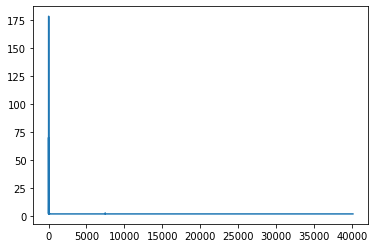

In [19]:
plt.plot(losses)
plt.show()

In [0]:
import json
json.dump(losses, open(model_dir + 'losses.json', 'w'), indent=4)

In [17]:
model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

17919105